In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
import tqdm

from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

## Load data

In [2]:
PATH_TO_DATA = "../data/exposure/mammals_nd1/"

### Load observed mutations

In [3]:
path_to_mutations_simple = os.path.join(PATH_TO_DATA, "simple/mutations.tsv")
path_to_mutations_proba = os.path.join(PATH_TO_DATA, "proba/mutations.tsv")
path_to_mutations_proba_no_coef = os.path.join(PATH_TO_DATA, "proba-no-phylocoef/mutations.tsv")
path_to_mutations_pastml = os.path.join(PATH_TO_DATA, "pastml/mutations.tsv")

mut_simple = pd.read_csv(path_to_mutations_simple, sep='\t')
mut_iqtree = pd.read_csv(path_to_mutations_proba, sep='\t')
mut_iqtree_no_coef = pd.read_csv(path_to_mutations_proba_no_coef, sep='\t')
mut_pastml = pd.read_csv(path_to_mutations_pastml, sep='\t')

mut_simple["MutBase"] = mut_simple["Mut"].str.slice(2, 5)
mut_iqtree["MutBase"] = mut_iqtree["Mut"].str.slice(2, 5)
mut_iqtree_no_coef["MutBase"] = mut_iqtree_no_coef["Mut"].str.slice(2, 5)
mut_pastml["MutBase"] = mut_pastml["Mut"].str.slice(2, 5)

### Load expected mutations freqs

In [4]:
path_to_freqs_simple = os.path.join(PATH_TO_DATA, "simple/expected_mutations.tsv")
path_to_freqs_iqtree = os.path.join(PATH_TO_DATA, "proba/expected_mutations.tsv")
path_to_freqs_iqtree_no_coef = os.path.join(PATH_TO_DATA, "proba-no-phylocoef/expected_mutations.tsv")
path_to_freqs_pastml = os.path.join(PATH_TO_DATA, "pastml/expected_mutations.tsv")

freqs_simple = pd.read_csv(path_to_freqs_simple, sep='\t').drop_duplicates()
freqs_iqtree = pd.read_csv(path_to_freqs_iqtree, sep='\t').drop_duplicates()
freqs_iqtree_no_coef = pd.read_csv(path_to_freqs_iqtree_no_coef, sep='\t').drop_duplicates()
freqs_pastml = pd.read_csv(path_to_freqs_pastml, sep='\t').drop_duplicates()

freqs_simple.shape, freqs_iqtree.shape, freqs_pastml.shape

((3966, 207), (3966, 207), (3969, 207))

In [5]:
freqs_pastml.head()

,Node,Gene,Label,A>C,A>G,A>T,C>A,C>G,C>T,G>A,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,ROOT,1,all,286.228183,286.228183,286.228183,272.039951,272.039951,272.039951,121.530859,...,7.147735,20.316258,9.520973,6.136815,2.216795,5.280824,22.170939,23.300497,7.370720,20.139228
1,ROOT,1,syn,90.429832,144.857590,90.429832,48.550482,48.550482,123.858539,14.042830,...,2.893562,3.269770,0.545331,0.622654,0.682865,0.432585,3.300758,2.641600,2.280555,1.476482
2,ROOT,1,ff,90.429832,90.429832,90.429832,48.550482,48.550482,48.550482,7.825675,...,2.893562,3.269770,0.545331,0.622654,0.682865,0.432585,3.300758,2.641600,2.280555,1.476482
3,Node1242,1,all,295.321291,295.321291,295.321291,281.099113,281.099113,281.099113,122.294678,...,6.705045,12.787300,12.270232,6.125435,2.519998,5.046903,16.252622,20.623208,4.483362,11.902204
4,Node1242,1,syn,101.604511,154.081346,101.604511,50.069435,50.069435,138.997007,14.590150,...,2.512212,1.957559,0.639060,0.739068,0.425249,0.553099,2.139483,2.119761,1.322645,0.545725


### Load edges mutational spectra

In [6]:
mutspec_simple12 = pd.read_csv(os.path.join(PATH_TO_DATA, "simple/mutspec12.tsv"), sep='\t')
mutspec_iqtree12 = pd.read_csv(os.path.join(PATH_TO_DATA, "proba/mutspec12.tsv"), sep='\t')
mutspec_iqtree_no_coef12 = pd.read_csv(os.path.join(PATH_TO_DATA, "proba-no-phylocoef/mutspec12.tsv"), sep='\t')
mutspec_pastml12 = pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutspec12.tsv"), sep='\t')

mutspec_simple192 = pd.read_csv(os.path.join(PATH_TO_DATA, "simple/mutspec192.tsv"), sep='\t')
mutspec_iqtree192 = pd.read_csv(os.path.join(PATH_TO_DATA, "proba/mutspec192.tsv"), sep='\t')
mutspec_iqtree_no_coef192 = pd.read_csv(os.path.join(PATH_TO_DATA, "proba-no-phylocoef/mutspec192.tsv"), sep='\t')
mutspec_pastml192 = pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutspec192.tsv"), sep='\t')

## Brief analysis of observed mutations

In [7]:
print(mut_simple.shape)
mut_simple.head()

(75946, 12)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene,MutBase
0,G[T>C]A,2,102,3,CGT,CGC,R,R,Node1242,Node1243,1,T>C
1,C[A>C]A,2,375,3,TCA,TCC,S,S,Node1242,Node1243,1,A>C
2,A[T>C]G,1,426,3,TAT,TAC,Y,Y,Node1242,Node1243,1,T>C
3,T[A>C]T,2,624,3,GTA,GTC,V,V,Node1242,Node1243,1,A>C
4,C[A>T]G,2,627,3,TCA,TCT,S,S,Node1242,Node1243,1,A>T


In [8]:
print(mut_iqtree.shape)
mut_iqtree.head()

(1186310, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,T[C>T]A,1,6,3,TTC,TTT,F,F,0.251434,0.170464,0.154744,Node1242,Node1243,1,C>T
1,T[T>C]A,1,6,3,TTT,TTC,F,F,0.676315,0.173435,0.157441,Node1242,Node1243,1,T>C
2,T[C>T]G,1,6,3,TTC,TTT,F,F,0.019502,0.000925,0.000839,Node1242,Node1243,1,C>T
3,T[T>C]G,1,6,3,TTT,TTC,F,F,0.052458,0.000941,0.000854,Node1242,Node1243,1,T>C
4,C[A>G]T,0,7,1,ATA,GTA,M,V,0.224317,0.003597,0.003265,Node1242,Node1243,1,A>G


In [9]:
print(mut_iqtree_no_coef.shape)
mut_iqtree_no_coef.head()

(1186310, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,T[C>T]A,1,6,3,TTC,TTT,F,F,0.251434,0.170464,0.170464,Node1242,Node1243,1,C>T
1,T[T>C]A,1,6,3,TTT,TTC,F,F,0.676315,0.173435,0.173435,Node1242,Node1243,1,T>C
2,T[C>T]G,1,6,3,TTC,TTT,F,F,0.019502,0.000925,0.000925,Node1242,Node1243,1,C>T
3,T[T>C]G,1,6,3,TTT,TTC,F,F,0.052458,0.000941,0.000941,Node1242,Node1243,1,T>C
4,C[A>G]T,0,7,1,ATA,GTA,M,V,0.224317,0.003597,0.003597,Node1242,Node1243,1,A>G


In [10]:
print(mut_pastml.shape)
mut_pastml.head()

(1330609, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,G[C>T]C,0,4,1,CCC,TCC,P,S,0.018706,0.018706,0.018706,ROOT,OUTGRP,1,C>T
1,T[A>C]C,0,5,2,TAC,TCC,Y,S,0.031802,0.031802,0.031802,ROOT,OUTGRP,1,A>C
2,T[T>C]C,0,5,2,TTC,TCC,F,S,0.238171,0.238171,0.238171,ROOT,OUTGRP,1,T>C
3,C[T>C]G,2,6,3,TCT,TCC,S,S,0.020677,0.020677,0.020677,ROOT,OUTGRP,1,T>C
4,C[A>G]C,0,7,1,ACA,GCA,T,A,0.112595,0.112595,0.112595,ROOT,OUTGRP,1,A>G


### Simple

In [11]:
mutations_summary(mut_simple, "Gene")

,non-syn,syn,syn4f,Stop loss,Stop gain
Gene,,,,,
1,8358,67575,35267,9,4


### Proba iqtree with evol coef

In [12]:
msum_pr = mutations_summary(mut_iqtree, "Gene", "ProbaFull")
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
1,8143.3,107114.1,59834.8,8.9,4.5,0.1


#### Filtration of IQTREE by probability

In [13]:
_mtypes_cnt = mut_iqtree.groupby("Label").ProbaFull.sum()
print("IQTREE: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))

IQTREE: 0.00012% of all sbs are stop loss/gain sbs


In [17]:
_mtypes_cnt = mut_iqtree[mut_iqtree.ProbaFull > 0.3].groupby("Label").ProbaFull.sum()
print("IQTREE filtered: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))
_mtypes_cnt

IQTREE filtered: 0.00006% of all sbs are stop loss/gain sbs


Label
-2        1.805370
-1        1.721234
 0     4862.247495
 1    24375.157505
 2    25296.677001
Name: ProbaFull, dtype: float64

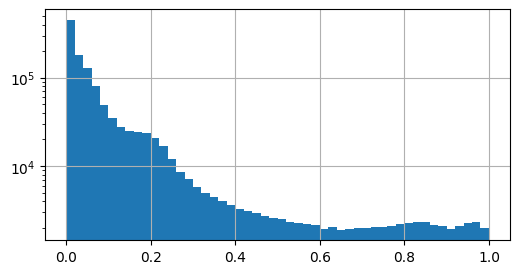

In [18]:
plt.figure(figsize=(6, 3))
mut_iqtree.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.show()

### Proba iqtree without evol coef

In [19]:
msum_pr = mutations_summary(mut_iqtree_no_coef, "Gene", "ProbaFull")
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
1,8677.1,113404.3,63486.2,10.0,5.1,0.1


#### Filtration of IQTREE by probability

In [20]:
_mtypes_cnt = mut_iqtree_no_coef.groupby("Label").ProbaFull.sum()
print("IQTREE: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))

IQTREE: 0.00012% of all sbs are stop loss/gain sbs


In [22]:
_mtypes_cnt = mut_iqtree_no_coef[mut_iqtree_no_coef.ProbaFull > 0.3].groupby("Label").ProbaFull.sum()
print("IQTREE filtered: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))
_mtypes_cnt

IQTREE filtered: 0.00007% of all sbs are stop loss/gain sbs


Label
-2        2.231295
-1        1.787963
 0     5204.853408
 1    26180.982377
 2    27494.860164
Name: ProbaFull, dtype: float64

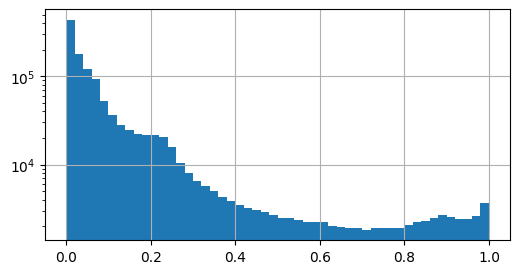

In [23]:
plt.figure(figsize=(6, 3))
mut_iqtree_no_coef.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.show()

### Proba pastml

In [24]:
msum_pr = mutations_summary(mut_pastml, "Gene", "ProbaFull")
msum_pr["syn"] += msum_pr["syn4f"]
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
1,9005.7,177430.0,58877.7,10.7,5.4,0.0


#### Filtration of PASTML by probability

In [25]:
_mtypes_cnt = mut_pastml.groupby("Label").ProbaFull.sum()
print("PASTML: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))
_mtypes_cnt

PASTML: 0.00013% of all sbs are stop loss/gain sbs


Label
-3        0.031085
-2       10.689479
-1        5.442637
 0     9005.710632
 1    59674.562716
 2    58877.739202
Name: ProbaFull, dtype: float64

In [26]:
_mtypes_cnt = mut_pastml[mut_pastml.ProbaFull > 0.3].groupby("Label").ProbaFull.sum()
print("PASTML filtered: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))
_mtypes_cnt

PASTML filtered: 0.00006% of all sbs are stop loss/gain sbs


Label
-2        1.936529
-1        1.611994
 0     5088.360839
 1    26335.949191
 2    26792.370113
Name: ProbaFull, dtype: float64

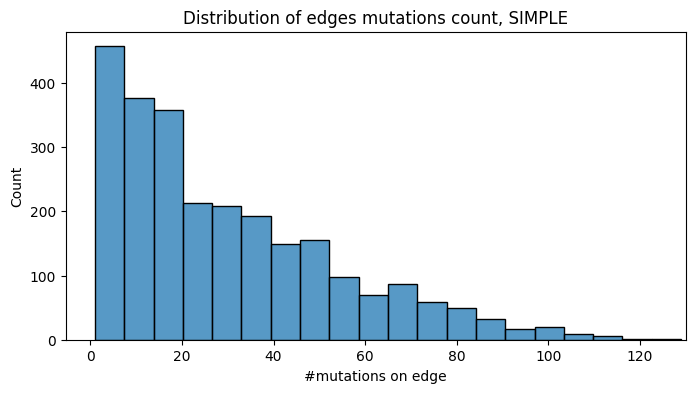

In [30]:
plt.figure(figsize=(8, 4))
sns.histplot(mut_simple.AltNode.value_counts(), bins=20)
plt.title("Distribution of edges mutations count, SIMPLE")
plt.xlabel("#mutations on edge")
plt.xlim(None, 130)
plt.show()

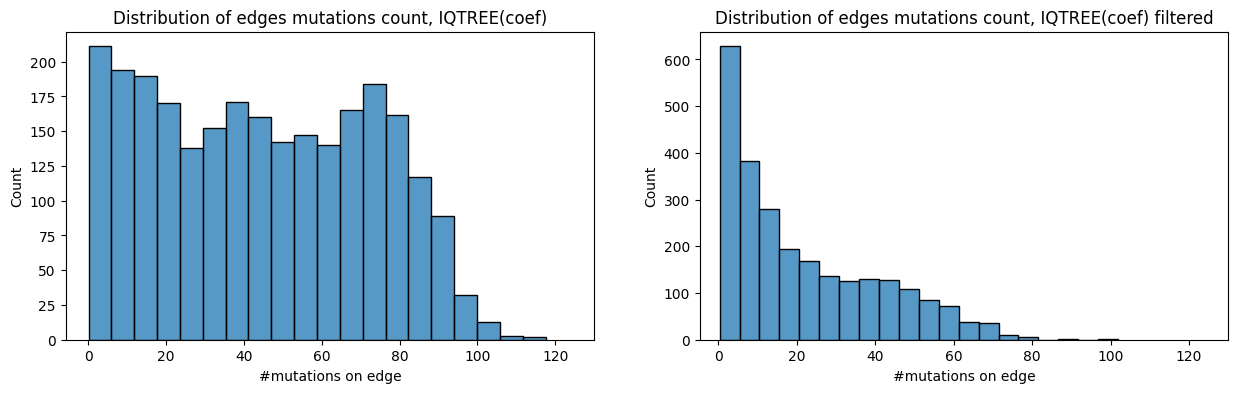

In [31]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
sns.histplot(mut_iqtree.groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, IQTREE(coef)")
plt.xlabel("#mutations on edge")
plt.xlim(None, 130)
plt.subplot(122)
sns.histplot(mut_iqtree[mut_iqtree.ProbaFull > 0.3].groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, IQTREE(coef) filtered")
plt.xlabel("#mutations on edge")
plt.xlim(None, 130)
plt.show()

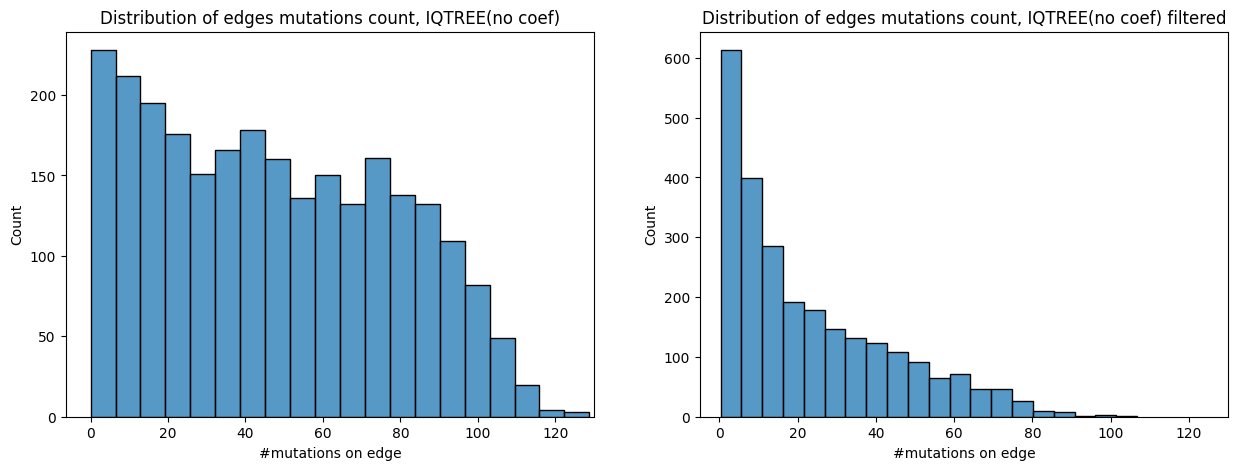

In [35]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(mut_iqtree_no_coef.groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, IQTREE(no coef)")
plt.xlabel("#mutations on edge")
plt.xlim(None, 130)
plt.subplot(122)
sns.histplot(mut_iqtree_no_coef[mut_iqtree_no_coef.ProbaFull > 0.3].groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, IQTREE(no coef) filtered")
plt.xlabel("#mutations on edge")
plt.xlim(None, 130)
plt.show()

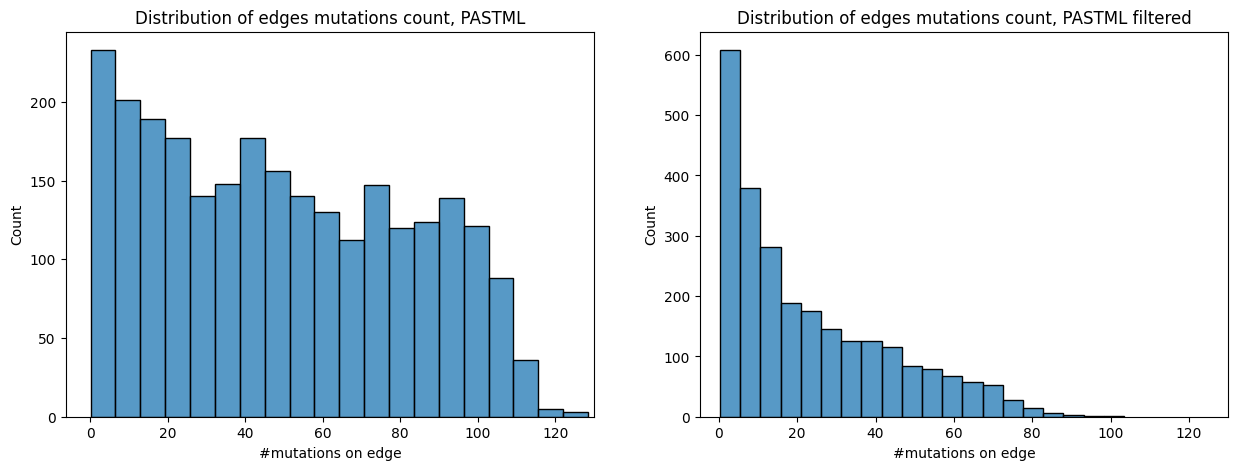

In [34]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(mut_pastml.groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, PASTML")
plt.xlabel("#mutations on edge")
plt.xlim(None, 130)
plt.subplot(122)
sns.histplot(mut_pastml[mut_pastml.ProbaFull > 0.3].groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, PASTML filtered")
plt.xlabel("#mutations on edge")
plt.xlim(None, 130)
plt.show()

## Mutspec

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


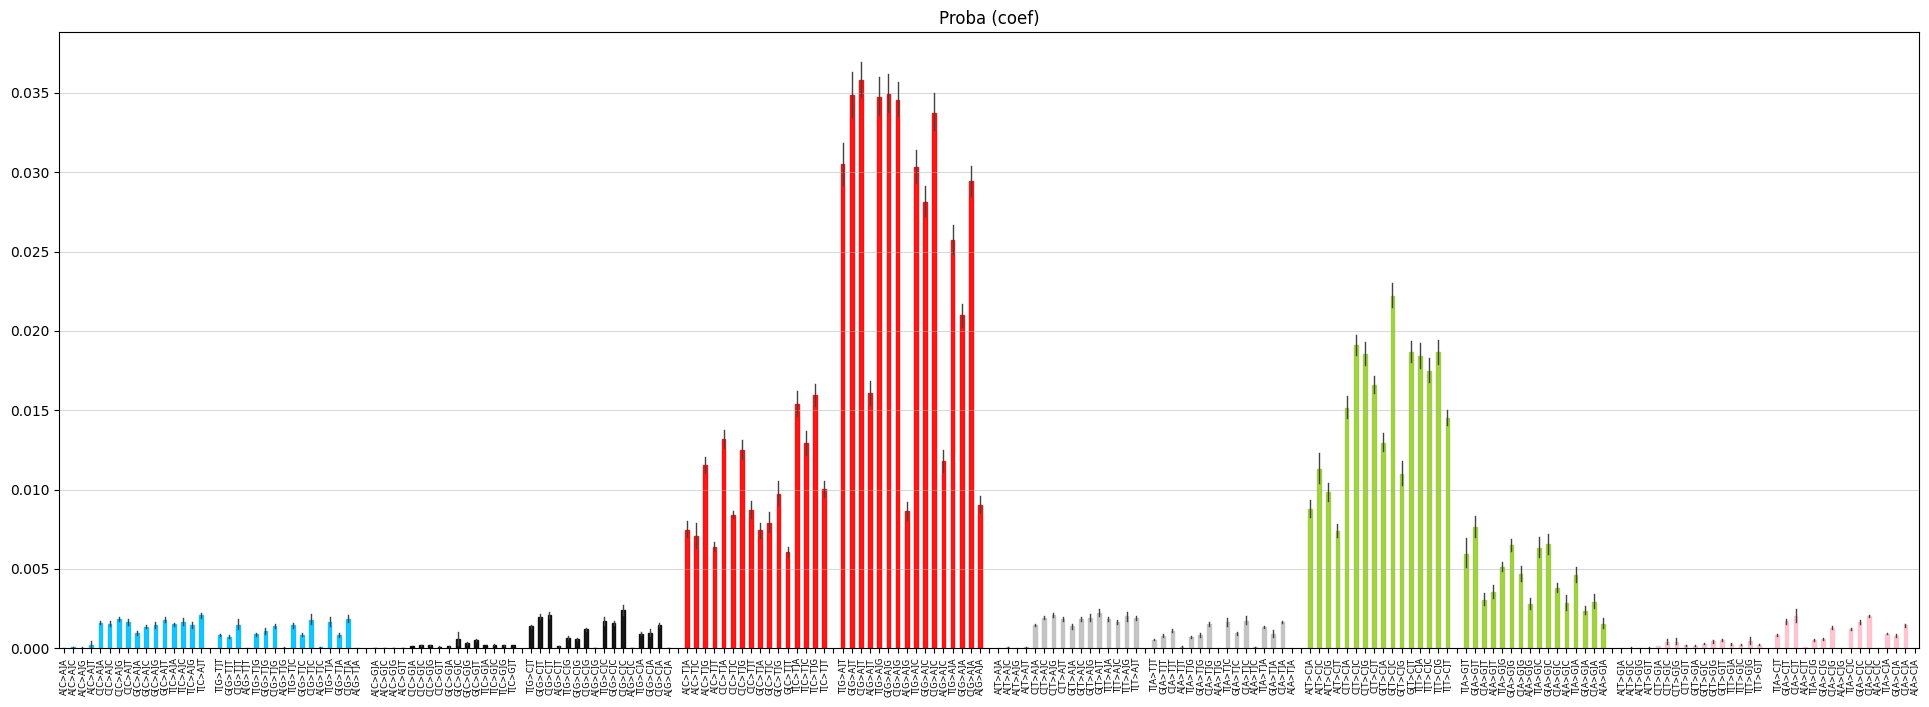

In [36]:
plot_mutspec192(mutspec_iqtree192, title="Proba (coef)")

In [37]:
sims_data12 = []
for lbl in mutspec_simple12.Label.unique():
    for anode in tqdm.tqdm(set(mutspec_simple12.AltNode), lbl):
        df1 = mutspec_simple12[(mutspec_simple12.Label == lbl) & (mutspec_simple12.AltNode == anode)].set_index("Mut").sort_index()
        df2 = mutspec_iqtree12[(mutspec_iqtree12.Label == lbl) & (mutspec_iqtree12.AltNode == anode)].set_index("Mut").sort_index()
        df3 = mutspec_pastml12[(mutspec_pastml12.Label == lbl) & (mutspec_pastml12.AltNode == anode)].set_index("Mut").sort_index()

        if len(df1) < 10 or len(df2) < 10 or len(df3) < 10:
            continue

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data12.append({
            "Label": "syn4f" if lbl == "ff" else lbl, 
            "AltNode": anode, 
            "cossim simple&iqtree": sim12, "cossim simple&pastml": sim13, "cossim iqtree&pastml": sim23,
        })
sims_df12 = pd.DataFrame(sims_data12).sort_values("Label")

ff: 100%|██████████| 2557/2557 [02:03<00:00, 20.69it/s]


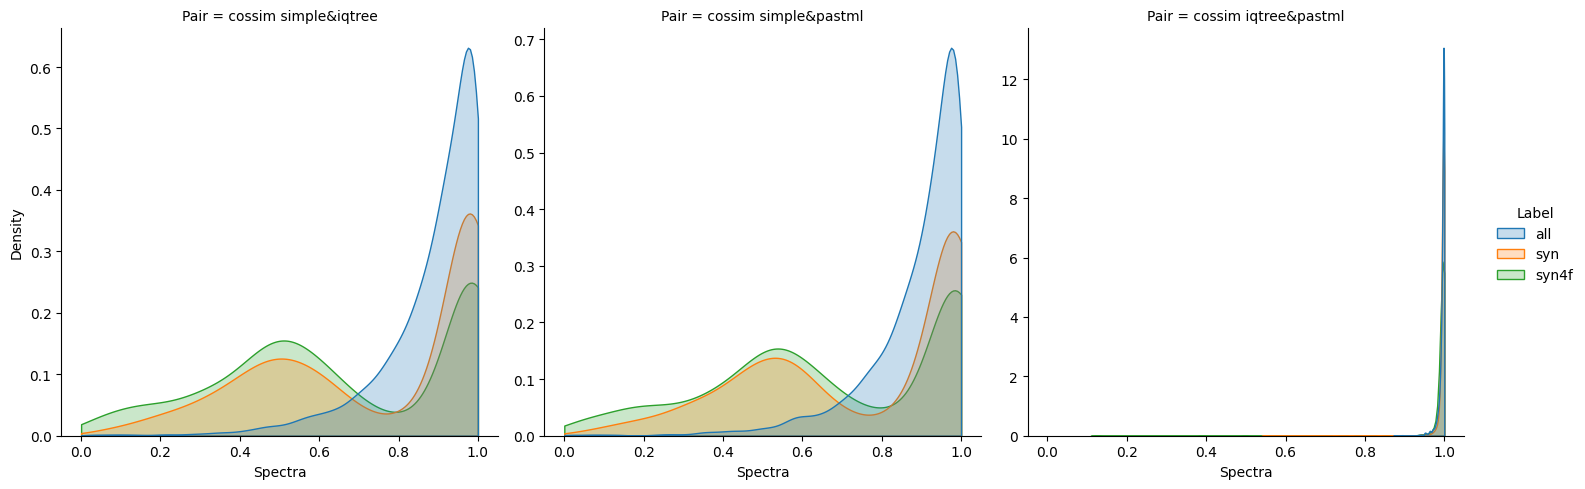

In [39]:
sns.displot(
    data=sims_df12.melt("Label", sims_df12.columns[-3:], "Pair", "Spectra"), 
    x="Spectra", col="Pair", hue="Label", 
    kind="kde", fill=True, clip=(0, 1),
    facet_kws=dict(sharex=True, sharey=False),
);

In [50]:
sims_data192 = []
for lbl in mutspec_simple192.Label.unique():
    df_simple = mutspec_simple192[(mutspec_simple192.Label == lbl)]
    df_iqtree = mutspec_iqtree192[(mutspec_iqtree192.Label == lbl)]
    df_pastml = mutspec_pastml192[(mutspec_pastml192.Label == lbl)]
                            
    for anode in tqdm.tqdm(set(mutspec_simple192.AltNode), lbl):
        nmut = 50

        df1 = df_simple[(df_simple.AltNode == anode)].set_index("Mut").sort_index()
        if (df1.MutSpec > 0).sum() < nmut:
            continue
        df2 = df_iqtree[(df_iqtree.AltNode == anode)].set_index("Mut").sort_index()
        if (df2.MutSpec > 0).sum() < nmut:
            continue
        df3 = df_pastml[(df_pastml.AltNode == anode)].set_index("Mut").sort_index()
        if (df3.MutSpec > 0).sum() < nmut:
            continue

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data192.append({
            "Label": "syn4f" if lbl == "ff" else lbl, 
            "AltNode": anode, 
            "cossim simple&iqtree": sim12, "cossim simple&pastml": sim13, "cossim iqtree&pastml": sim23,
        })
sims_df192 = pd.DataFrame(sims_data192).sort_values("Label")
sims_df192.to_csv("../data/sims_df192_nd1.csv", index=False)

ff: 100%|██████████| 2557/2557 [01:46<00:00, 23.96it/s]


all    51
syn     7
Name: Label, dtype: int64


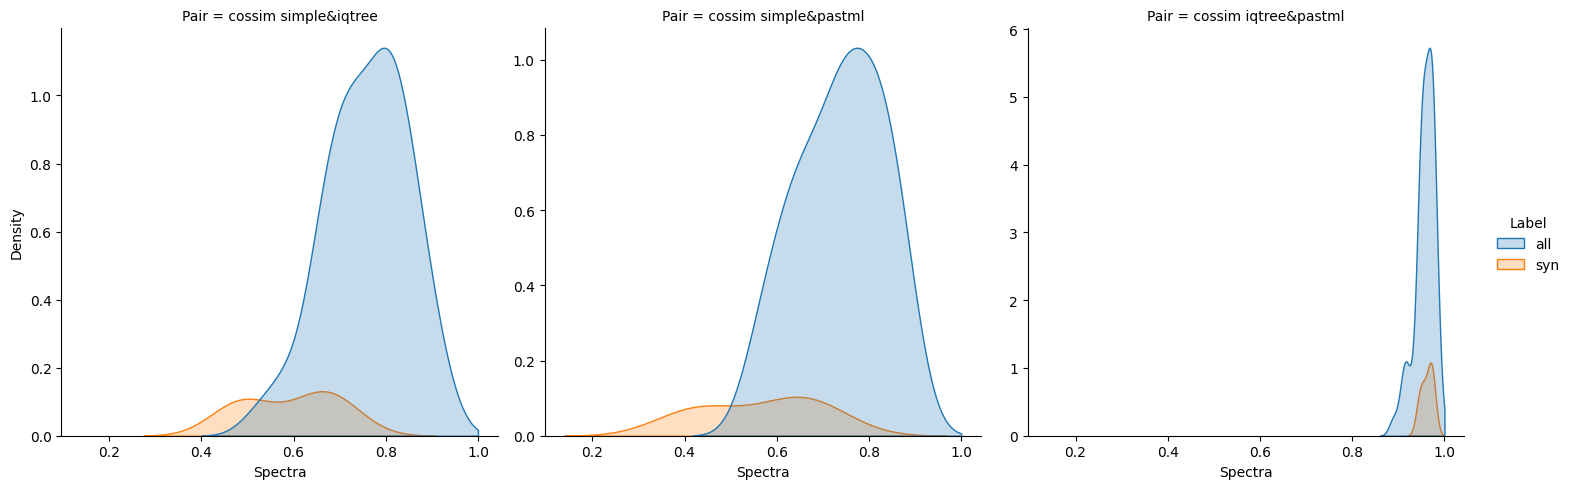

In [51]:
print(sims_df192.Label.value_counts())
sns.displot(
    data=sims_df192.melt("Label", sims_df192.columns[-3:], "Pair", "Spectra"), 
    x="Spectra", col="Pair", hue="Label", 
    kind="kde", fill=True, clip=(0, 1),
    facet_kws=dict(sharex=True, sharey=False),
)
plt.show()

## Categorizing mutations
We need to explore what mutations sample is responible for the bias

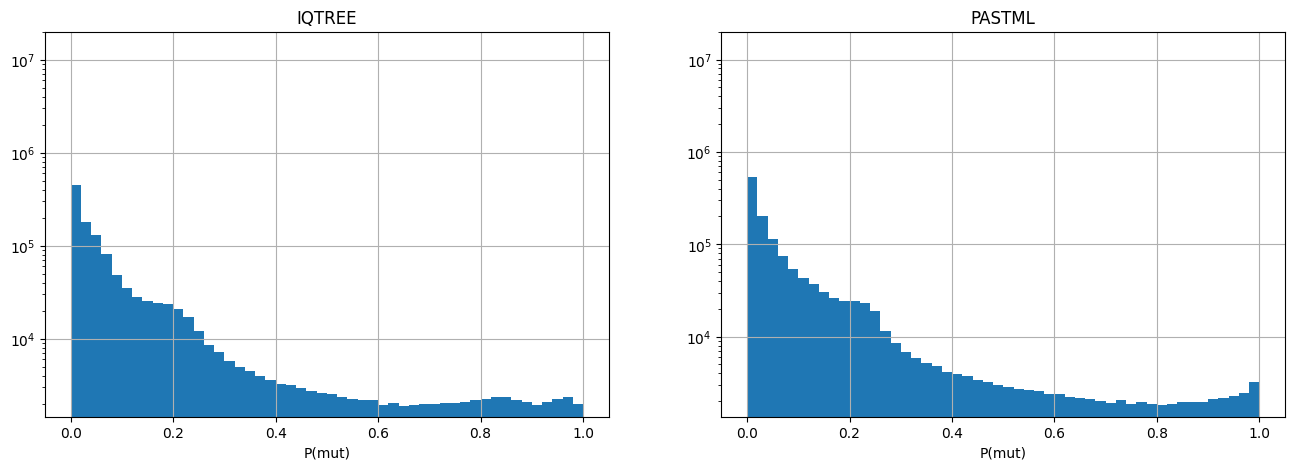

In [40]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
mut_iqtree.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.title("IQTREE")
plt.xlabel("P(mut)")
plt.ylim(0, 2e7)

plt.subplot(1,2,2)
mut_pastml.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.title("PASTML")
plt.xlabel("P(mut)")
plt.ylim(0, 2e7)
plt.show()

# НАЛОЖИТЬ В ОДИН

Сколько мутаций в каждом интервале вероятностей у обоих подходов

In [41]:
print("p1\tp2\t#iqtree\t#pastml")
for x1 in np.linspace(0, 1, 21)[:-1]:
    x2 = x1 + 0.05
    mut_exp_num_iqtree = mut_iqtree[(mut_iqtree.ProbaFull > x1) & (mut_iqtree.ProbaFull <= x2)].ProbaFull.sum()
    mut_exp_num_pastml = mut_pastml[(mut_pastml.ProbaFull > x1) & (mut_pastml.ProbaFull <= x2)].ProbaFull.sum()
    print(f"{x1:.2f}\t{x2:.2f}\t{mut_exp_num_iqtree:.1f}\t{mut_exp_num_pastml:.1f}")

p1	p2	#iqtree	#pastml
0.00	0.05	11787.4	12730.3
0.05	0.10	13418.1	12738.3
0.10	0.15	9300.3	11845.7
0.15	0.20	10529.5	11455.4
0.20	0.25	9875.8	13015.7
0.25	0.30	5822.3	7568.6
0.30	0.35	4253.2	4958.1
0.35	0.40	3631.6	4266.9
0.40	0.45	3396.4	3985.3
0.45	0.50	3197.8	3740.5
0.50	0.55	3159.1	3627.3
0.55	0.60	3154.0	3606.7
0.60	0.65	3089.5	3577.9
0.65	0.70	3283.7	3494.4
0.70	0.75	3645.3	3526.5
0.75	0.80	4135.9	3683.4
0.80	0.85	4781.2	3847.4
0.85	0.90	4718.7	4267.6
0.90	0.95	4758.4	4978.4
0.95	1.00	5332.8	6659.7


In [42]:
def calc_tree_mutspec(mut, freqs, lbl="syn", pmin=0.0, pmax=1.0, collapse=False):
    """
    calculate tree mutspec from history files
    
    return mutspec of each edge in one table
    """
    # sample mutations
    mut = mut[(mut.ProbaFull > pmin) & (mut.ProbaFull <= pmax)]
    
    mutspec = []
    for (ref_node, alt_node), cur_mut in mut.groupby(["RefNode", "AltNode"]):
        # sample freqs
        _cur_freq_df = freqs[(freqs.Node == ref_node) & (freqs.Label == lbl)]
        cur_freq = _cur_freq_df[possible_sbs192].sum(axis=0).to_dict()

        # calculate mutspec
        ms192 = calculate_mutspec(cur_mut[cur_mut.Label >= lbl2lbl_id(lbl)], cur_freq, use_context=True, use_proba=True)
        ms192["RefNode"] = ref_node
        ms192["AltNode"] = alt_node
        ms192["Label"] = lbl
        mutspec.append(ms192)
    mutspec_df = pd.concat(mutspec)
    if collapse:
        mutspec_df = mutspec_df.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
    mutspec_df["MutBase"] = mutspec_df.Mut.str.slice(2, 5)
    mutspec_df["Context"] = mutspec_df.Mut.str.get(0) + mutspec_df.Mut.str.get(2) + mutspec_df.Mut.str.get(-1)
    return mutspec_df

In [43]:
space = [0.00, 0.05, 0.30, .50, 0.80, 1.00]

In [44]:
for p1, p2 in zip(space[:-1], space[1:]):
    mut_exp_num_iqtree = mut_iqtree[(mut_iqtree.ProbaFull > p1) & (mut_iqtree.ProbaFull <= p2)].ProbaFull.sum()
    mut_exp_num_pastml = mut_pastml[(mut_pastml.ProbaFull > p1) & (mut_pastml.ProbaFull <= p2)].ProbaFull.sum()
    print(f"{p1:.2f}\t{p2:.2f}\t{mut_exp_num_iqtree:.1f}\t{mut_exp_num_pastml:.1f}")

0.00	0.05	11787.4	12730.3
0.05	0.30	48946.0	56623.7
0.30	0.50	14478.9	16950.8
0.50	0.80	20467.6	21516.2
0.80	1.00	19591.1	19753.2


In [45]:
ms_cat_iqtree = []
for p1, p2 in zip(space[:-1], space[1:]):
    ms = calc_tree_mutspec(mut_iqtree, freqs_iqtree, "syn", p1, p2)
    ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
    ms_cat_iqtree.append(ms)

ms_cat_iqtree_df = pd.concat(ms_cat_iqtree)

In [46]:
ms_cat_pastml = []
for p1, p2 in zip(space[:-1], space[1:]):
    ms = calc_tree_mutspec(mut_pastml, freqs_pastml, "syn", p1, p2)
    ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
    ms_cat_pastml.append(ms)

ms_cat_pastml_df = pd.concat(ms_cat_pastml)

### Categorized mutspec 

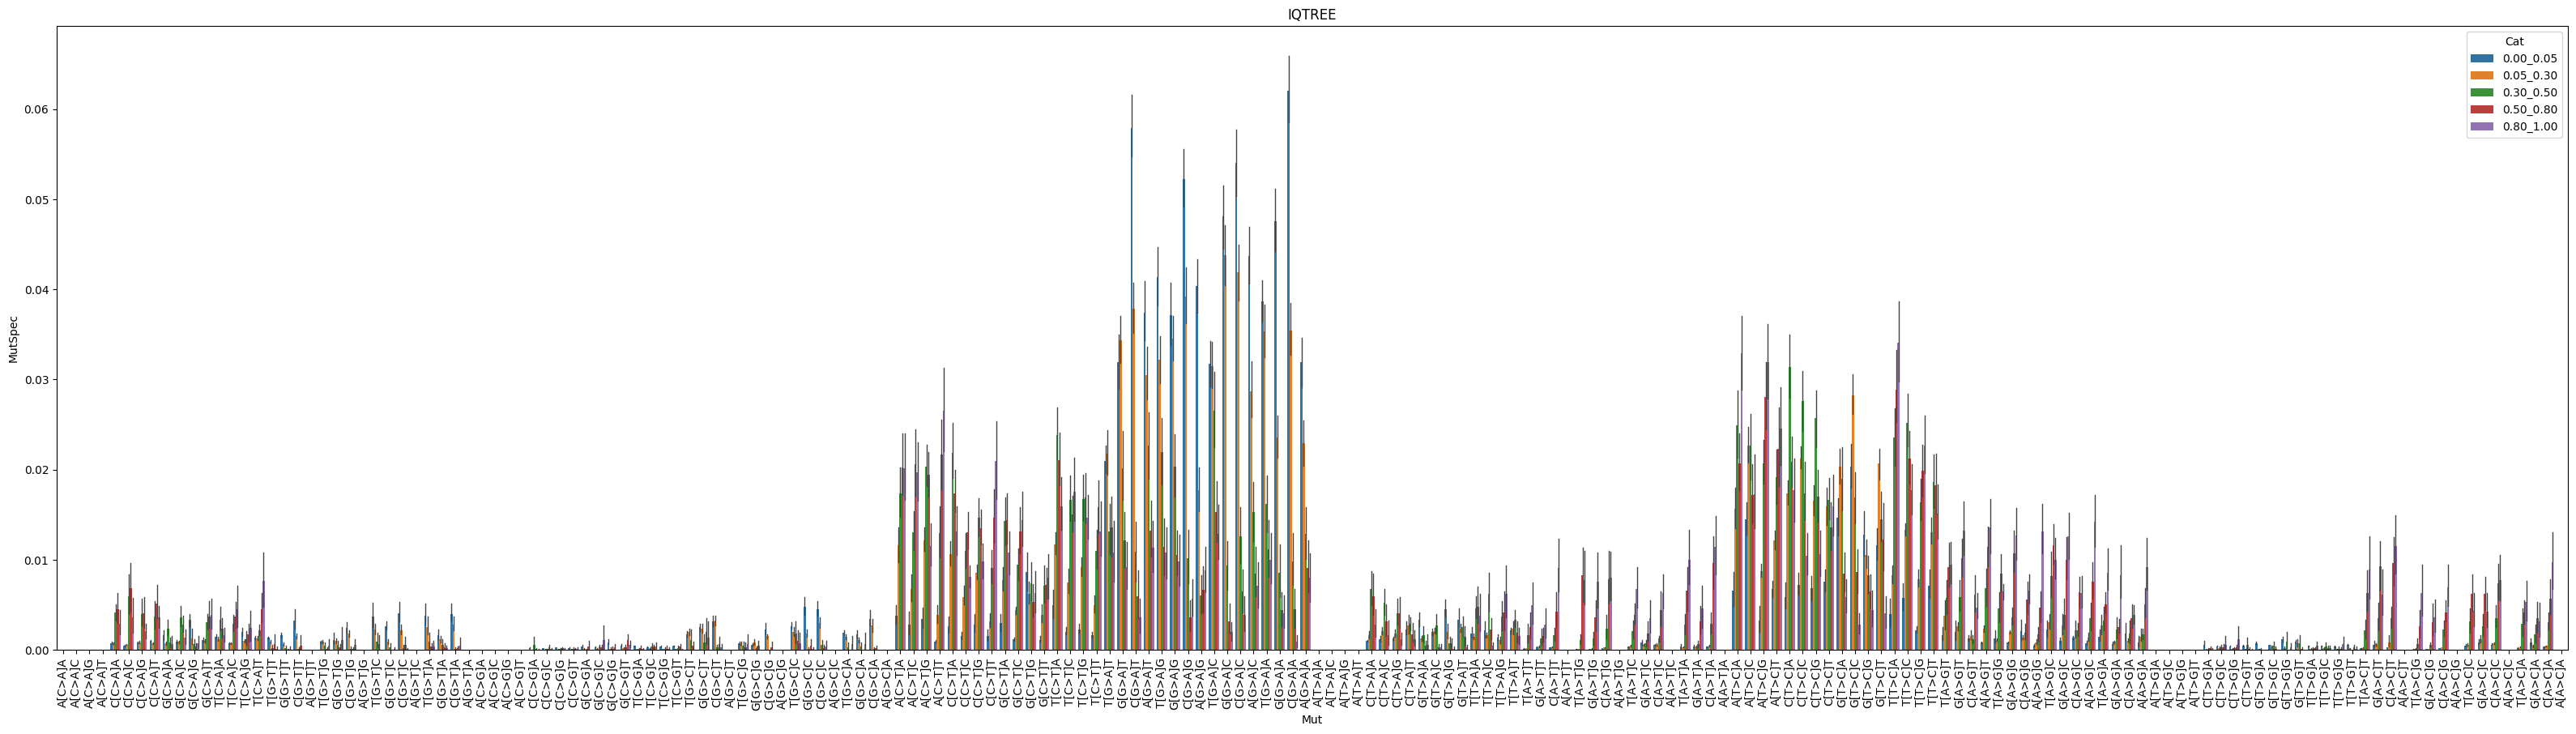

In [47]:
plt.figure(figsize=(40, 10))
sns.barplot(
    x="Mut", y="MutSpec", hue="Cat", data=ms_cat_iqtree_df, errwidth=1, order=ordered_sbs192_kp,
)
plt.title("IQTREE")
plt.xticks(rotation=90);

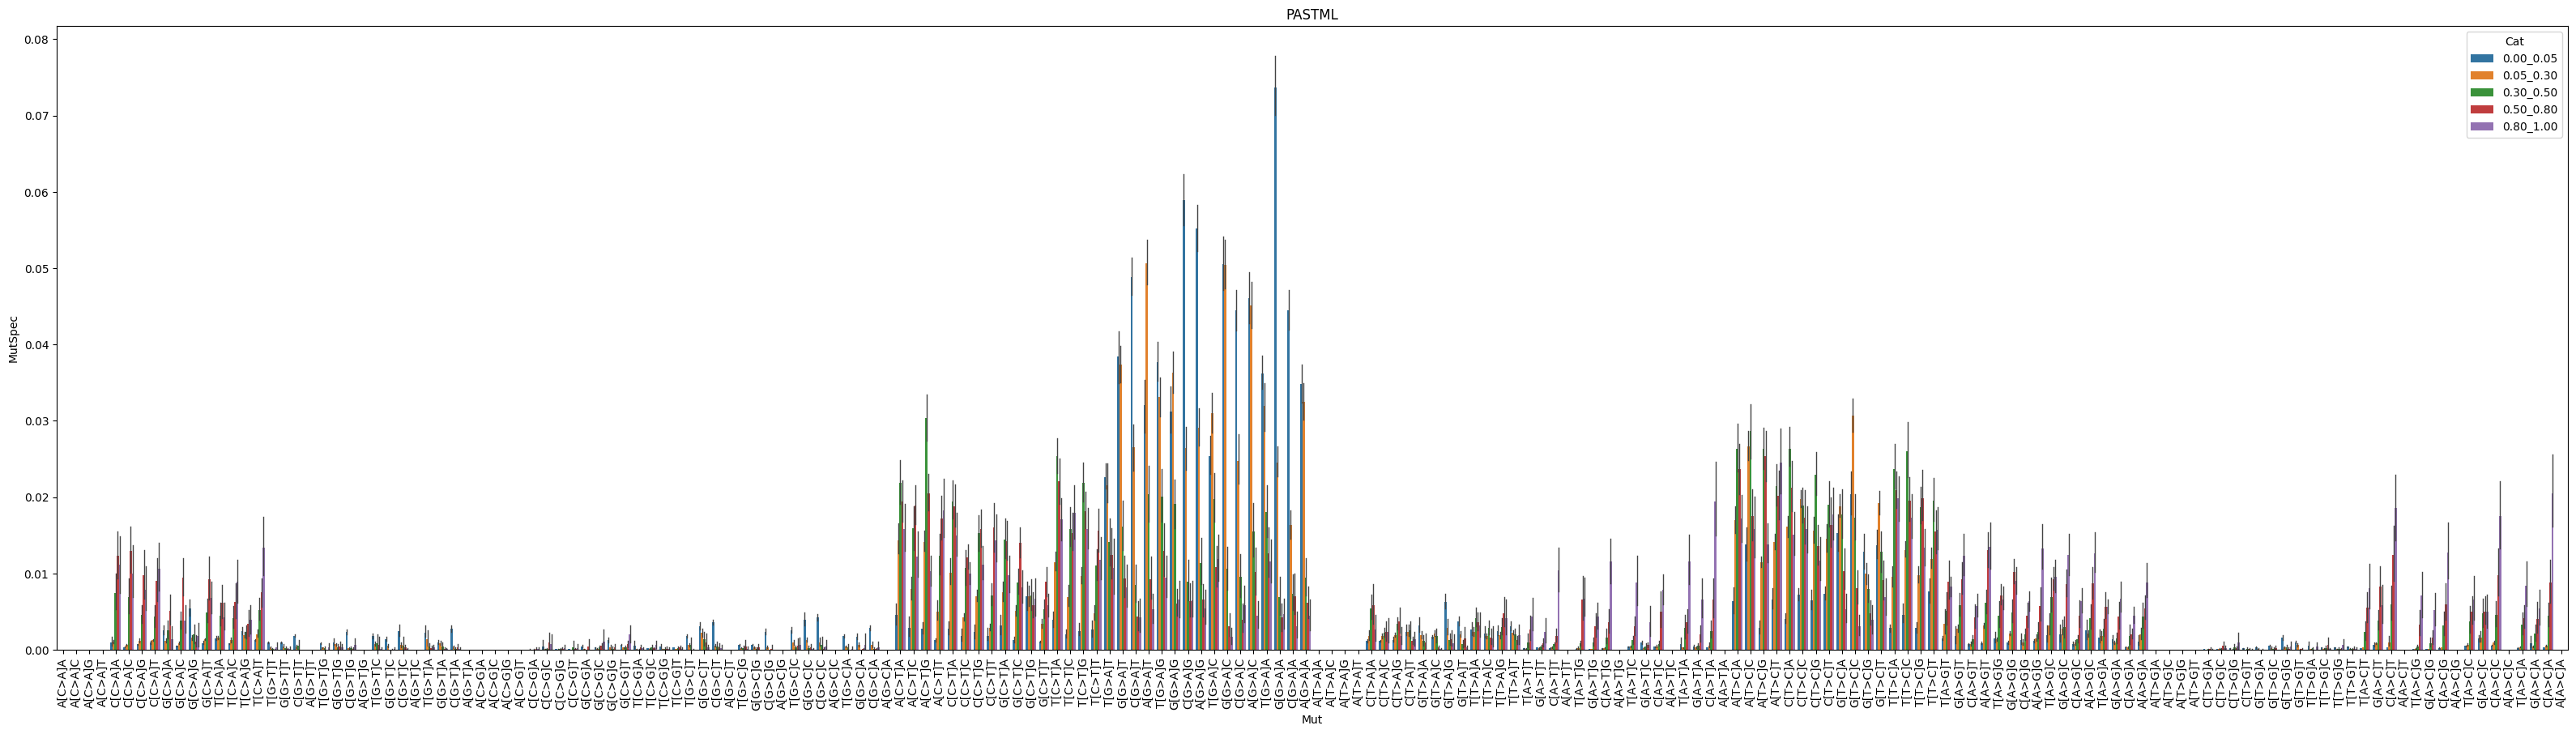

In [48]:
plt.figure(figsize=(40, 10))
sns.barplot(
    x="Mut", y="MutSpec", hue="Cat", data=ms_cat_pastml_df, errwidth=1, order=ordered_sbs192_kp,
)
plt.title("PASTML")
plt.xticks(rotation=90);

Разглядывать сложно. Но виден сильный дисбаланс.Как по низковероятным мутациям, так и по высоковероятным

### Compare cossim of mutspecs on mutations samples

In [28]:
def plot_compared(p1, p2, lbl="syn", constant_pastml=False):
    ms_simple = mutspec_simple192[(mutspec_simple192.Label == lbl)]
    ms_iqtree = calc_tree_mutspec(mut_iqtree, freqs_iqtree, lbl, p1, p2)
    if constant_pastml:
        ms_pastml = calc_tree_mutspec(mut_pastml, freqs_pastml, lbl, 0, 1)
    else:
        ms_pastml = calc_tree_mutspec(mut_pastml, freqs_pastml, lbl, p1, p2)
    sims_data = []
    for anode in set(mutspec_simple192.AltNode):
        df1 = ms_simple[(ms_simple.AltNode == anode)].set_index("Mut").sort_index()
        df2 = ms_iqtree[(ms_iqtree.AltNode == anode)].set_index("Mut").sort_index()
        df3 = ms_pastml[(ms_pastml.AltNode == anode)].set_index("Mut").sort_index()
        if not df1.shape or not df2.shape or not df3.shape:
            continue

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data.append({"AltNode": anode, "Pair": "simple & iqtree", "Cossim": sim12})
        sims_data.append({"AltNode": anode, "Pair": "iqtree & pastml", "Cossim": sim23})
        sims_data.append({"AltNode": anode, "Pair": "simple & pastml", "Cossim": sim13})

    sims_df = pd.DataFrame(sims_data)
    
    # https://python.plainenglish.io/ridge-plots-with-pythons-seaborn-4de5725881af
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
    palette = sns.color_palette("Set2", 12)
    g = sns.FacetGrid(sims_df, palette=palette, row="Pair", hue="Pair", aspect=4, height=2.0)
    g.map_dataframe(sns.kdeplot, x="Cossim", fill=True, alpha=1)
    g.map_dataframe(sns.kdeplot, x="Cossim", color='black')

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
        
    g.map(label, "Pair")
    g.fig.subplots_adjust(hspace=-.5)
    g.set_titles("")
    g.set(yticks=[], xlabel="cossim", ylabel="")
    g.despine(left=True)
    title = f"Proba: ({p1}, {p2}]"
    if constant_pastml:
        title = f"Proba: iqtree: ({p1}, {p2}]; pastml: (0, 1]"
    plt.suptitle(title, y=0.98)
    plt.xlim(0, 1.01)
    plt.xticks(np.linspace(-0.1, 1.1, 13))
    plt.show()

Ниже графики, в которых мутспек считается по подвыборке мутаций с указанной вероятностью. 

Сначала идут графики, где мутации фильтровались как для iqtree, так и для pastml. Далее идут графики, где мутации фильтруются только у iqtree

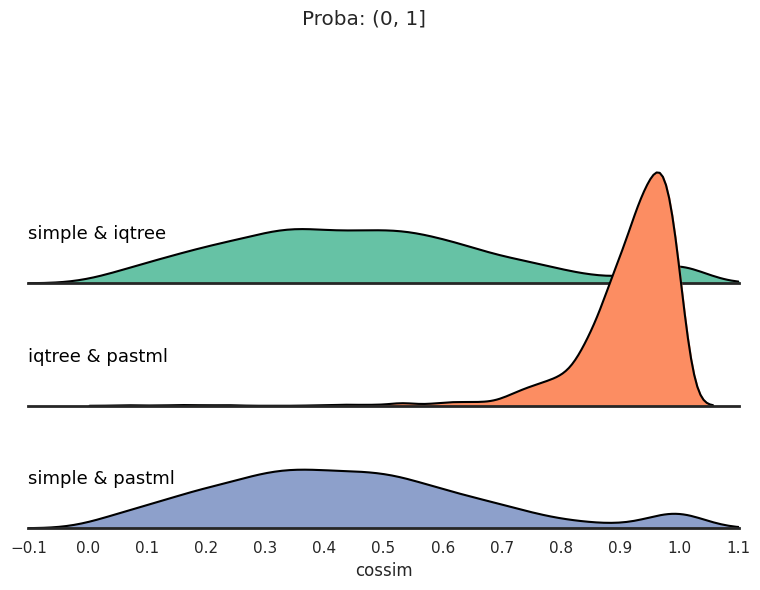

In [19]:
plot_compared(0, 1)

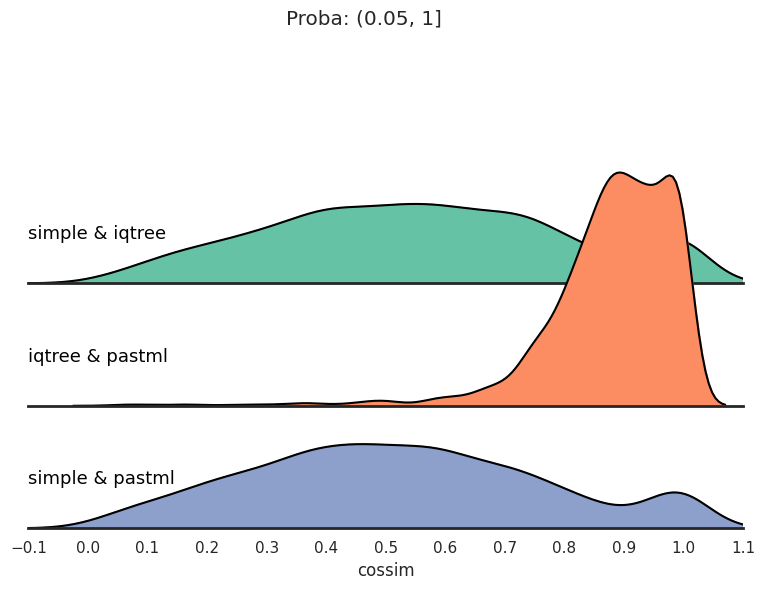

In [20]:
plot_compared(0.05, 1)

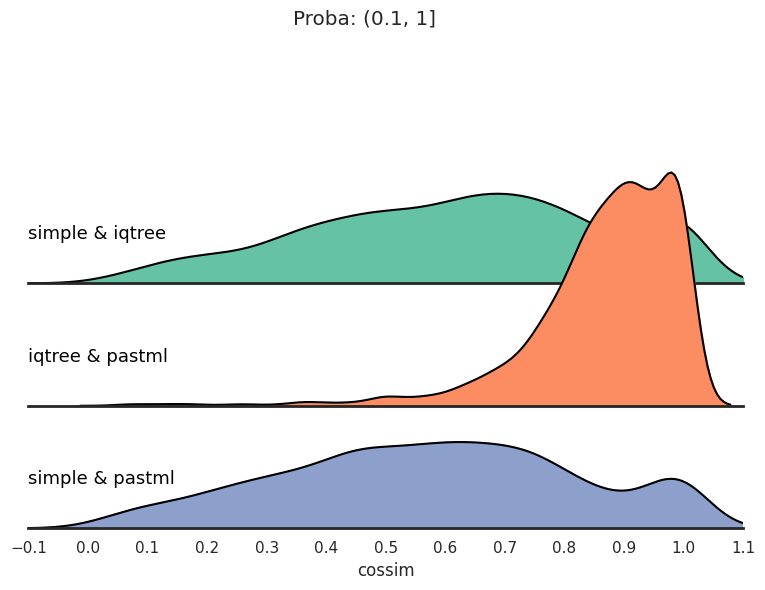

In [21]:
plot_compared(0.1, 1)

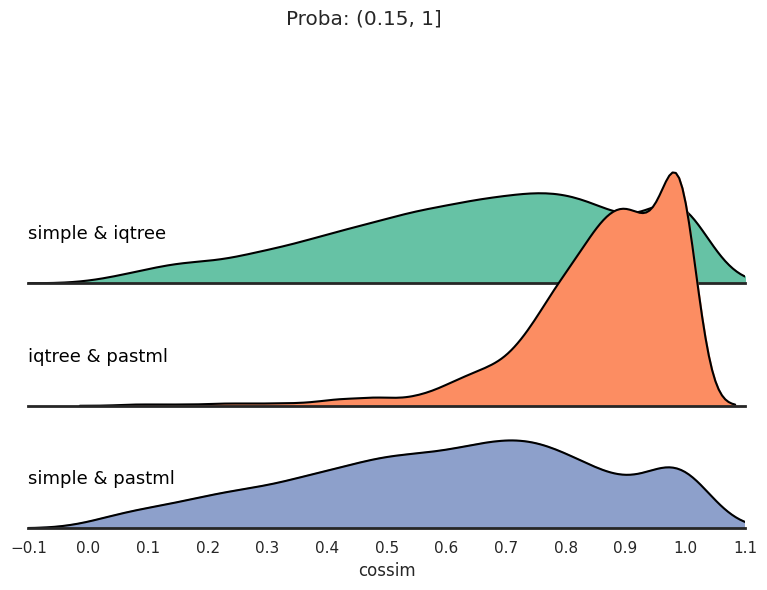

In [22]:
plot_compared(0.15, 1)

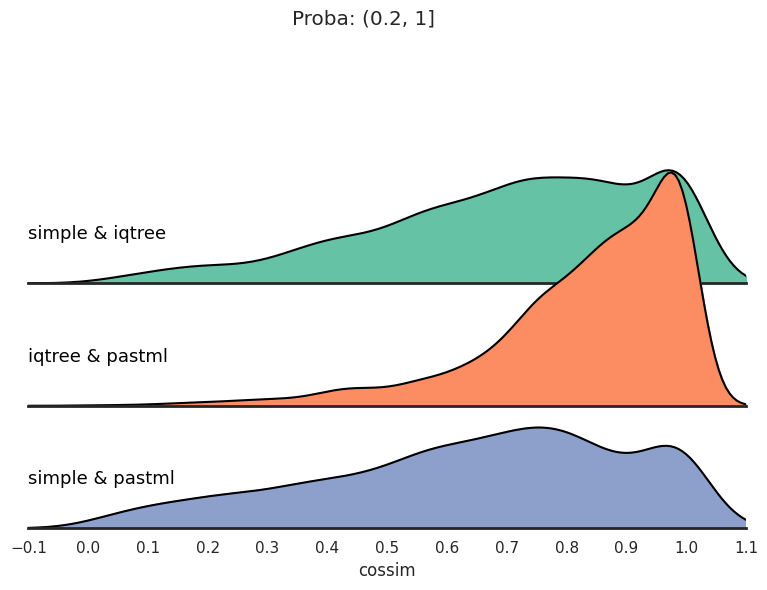

In [23]:
plot_compared(0.20, 1)

In [29]:
plot_compared(0.40, 1)

ValueError: operands could not be broadcast together with shapes (192,) (0,) 

Далее полная выборка мутаций из pastml сравнивается с разными выборками из iqtree

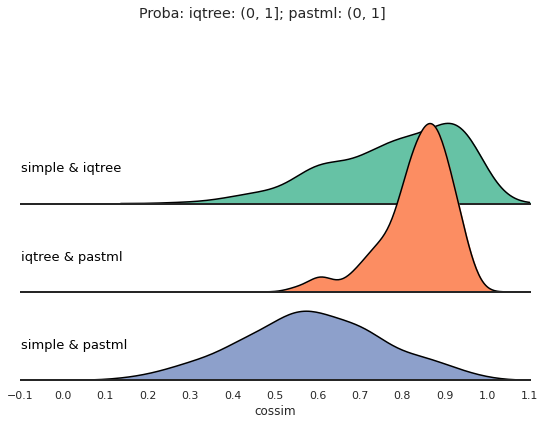

In [ ]:
plot_compared(0, 1, constant_pastml=True)

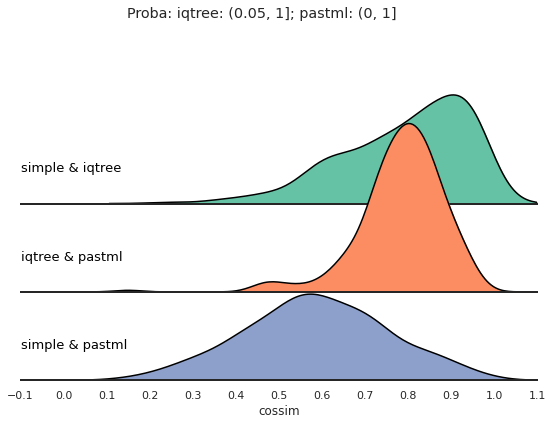

In [ ]:
plot_compared(0.05, 1, constant_pastml=True)

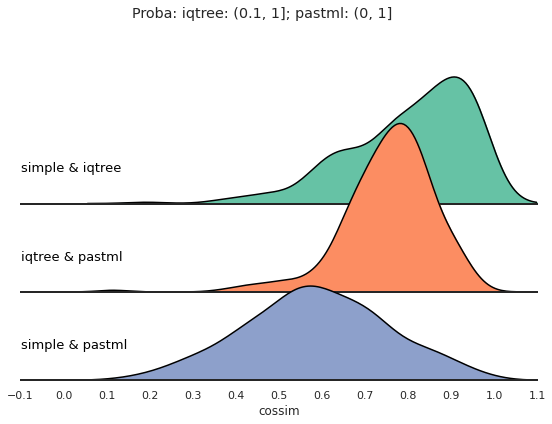

In [ ]:
plot_compared(0.1, 1, constant_pastml=True)

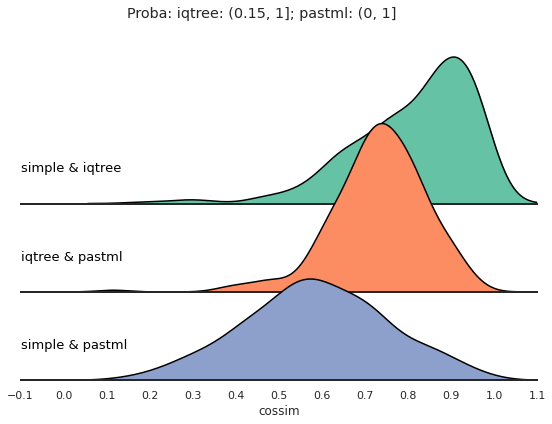

In [ ]:
plot_compared(0.15, 1, constant_pastml=True)